In [1]:
# Import a library to fetch web content using HTTP requests.
import requests
# Import a library to parse the HTML content of web pages.
from bs4 import BeautifulSoup
import pandas as pd
import urllib
import os
import numpy as np
import io
# Imports the Google Cloud client library
from google.cloud import vision
from google.cloud.vision import types
import math
import json
import matplotlib.pyplot as plt
import time
from src.companies_clean import companies_clean
import random
import pickle

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import string
from nltk.corpus import stopwords
sws = set(stopwords.words('english'))
punctuation = set(string.punctuation)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import TruncatedSVD

In [3]:
final_df = pd.read_pickle('data/final_df')

In [4]:
trend_moat = pd.read_pickle('data/trend_moat')

In [5]:
image_data = pd.read_pickle('data/image_data')

In [6]:
df_google = pd.read_pickle('data/df_google')

In [7]:
df_moat = pd.read_pickle('data/df_moat')

In [8]:
df_companies = companies_clean()

In [9]:
# companies_dummy = pd.get_dummies(df_companies['Categories_simple'].apply(pd.Series).stack()).sum(level=0) 

In [10]:
# df_companies = pd.merge(df_companies, companies_dummy, left_index=True, right_index=True)

In [11]:
# df_companies[df_companies['Organization Name'].str.contains('Bud')]
# df[df['A'].str.contains("hello")]

In [12]:
df_moat.sample()

Companies Brand   Brand      Image Name  First Seen   Last Seen  \
7186          Acquia  Acquia  Acquia7186.jpg  2019-06-04  2019-06-27   

                                             Screenpath  
7186  https://moatsearch-data.s3.amazonaws.com/creat...

In [13]:
df_moat['Last Seen'] =  pd.to_datetime(df_moat['Last Seen'])
df_moat['First Seen'] =  pd.to_datetime(df_moat['First Seen'])
df_moat['Campaign Length'] = df_moat['Last Seen'] - df_moat['First Seen']
df_moat['Campaign Length'] = df_moat['Campaign Length'].dt.days

In [14]:
color_dummy = image_data['color_round'].apply(pd.Series)

In [15]:
image_data['words'] = image_data['words'].apply(lambda x: x[1:])

In [16]:
image_data = pd.merge(image_data, color_dummy, left_index=True, right_index=True)

In [17]:
len(image_data), len(df_moat)

(4469, 9110)

In [18]:
final_df['campaign_success'] = final_df['campaign_score'] - final_df['before_score']

In [19]:
final_df['campaign_success'] = final_df['campaign_success'] >= 1

In [20]:
sum(final_df['campaign_success'])/len(final_df['campaign_success'])

0.4640633842671194

In [21]:
final_df = pd.merge(final_df, image_data, left_index=True, right_index=True)



In [22]:
final_df = pd.merge(df_moat[['Brand','Campaign Length']], final_df, left_index=True, right_index=True)



In [23]:
final_df['one_string_words'] = final_df['words'].apply(lambda x: ' '.join(x))

In [24]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=20)

#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(final_df['one_string_words'])
lsa_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))

#Creat meaningful column names
collist = map(str, range(0, 20))
collist = ["latent_description_" + s for s in collist]
lsa_features.columns = collist
lsa_features.head()

latent_description_0  latent_description_1  latent_description_2  \
0              0.090447             -0.077166             -0.019010   
1              0.071441             -0.076349             -0.038456   
2              0.080703             -0.072169             -0.022408   
3              0.055583             -0.014345              0.011910   
4              0.039359             -0.013569              0.013502   

   latent_description_3  latent_description_4  latent_description_5  \
0             -0.024890              0.009483             -0.026680   
1             -0.034916              0.027846             -0.024956   
2             -0.023862              0.012292             -0.024182   
3              0.012348             -0.001520             -0.015430   
4              0.000197             -0.001649             -0.012358   

   latent_description_6  latent_description_7  latent_description_8  \
0             -0.009204              0.086026              0.016351   
1             -0.011639              0.043280              0.007796   
2             -0.012092              0.076813              0.014349   
3             -0.021860              0.067424              0.043171   
4             -0.008765              0.051387              0.017190   

   latent_description_9  latent_description_10  latent_description_11  \
0             -0.015354               0.012126               0.019531   
1             -0.006437               0.010678               0.024675   
2             -0.012041               0.009918               0.015642   
3             -0.024200               0.013417              -0.005993   
4             -0.006190               0.000253               0.009048   

   latent_description_12  latent_description_13  latent_description_14  \
0              -0.006550               0.084412               0.006393   
1              -0.007631               0.049150              -0.001830   
2              -0.007956               0.063182              -0.004382   
3              -0.006308               0.066360              -0.017312   
4               0.001762               0.055936               0.002598   

   latent_description_15  latent_description_16  latent_description_17  \
0               0.002844               0.047040               0.091468   
1              -0.007344               0.030035               0.053302   
2              -0.010931               0.043605               0.080349   
3               0.006178               0.058179               0.097316   
4              -0.003657               0.036519               0.070975   

   latent_description_18  latent_description_19  
0              -0.103198              -0.003858  
1              -0.075753               0.011142  
2              -0.087659              -0.007067  
3              -0.085830              -0.017582  
4              -0.088124              -0.011857

<4469x1136 sparse matrix of type '<class 'numpy.float64'>'
	with 29846 stored elements in Compressed Sparse Row format>

In [28]:
final_df = pd.merge(final_df, lsa_features, left_index=True, right_index=True)

In [26]:
final_df[['Companies Brand',
 'Image Name',
 'First Seen',
 'Last Seen',
 'before_campaign',
 'after_campaign',
 'before_score',
 'campaign_score',
 'after_score',
 'campaign_success',
 'color_round']].sample()

Companies Brand     Image Name First Seen   Last Seen before_campaign  \
4277           ALICE  Alice4359.jpg 2016-05-22  2019-06-22      2016-01-22   

     after_campaign  before_score  campaign_score  after_score  \
4277     2016-09-22     63.929742            94.0    64.709677   

      campaign_success                                        color_round  
4277              True  {'apricot': 0, 'beige': 0, 'black': 0, 'blue':...

In [27]:
test_df = pd.merge(final_df, df_companies, left_on='Companies Brand', right_on='Moat Name', how='left')

In [28]:
# #Make atest train split
# X = pd.concat([lsa_features, wine["price"]], axis=1)
# y = wine["points"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# #Format data
# dtrain = xgb.DMatrix(X_train, label=y_train)
# dtest = xgb.DMatrix(X_test, label=y_test)

# #Set xgboost parameters
# param = {'max_depth': 3, 'eta': 1, 'subsample':0.5, 'alpha':1}
# param['nthread'] = 4
# param['eval_metric'] = 'mae'
# param['objective'] = 'reg:linear'
# param['silent'] = 1
# evallist = [(dtrain, 'train')]
# num_round = 10

# #Train model
# bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

In [29]:
test_df.drop(['Companies Brand',
 'Image Name',
 'First Seen',
 'Last Seen',
 'before_campaign',
 'after_campaign',
 'before_score',
 'campaign_score',
 'after_score',
 'color_round',
 'Organization Name',
 'Categories',
 'Description',
 'Founded',
 'Moat Name',
 'Categories_simple',
 'Headquarters Location',
 'one_string_words'], axis=1, inplace=True)

In [30]:
test_df.drop(['words'], axis=1, inplace=True)

In [31]:
test_df.drop(['Brand_x', 'Brand_y'], axis=1, inplace=True)

In [32]:
list(test_df)

['Campaign Length',
 'campaign_success',
 'apricot',
 'beige',
 'black',
 'blue',
 'brown',
 'cyan',
 'green',
 'grey',
 'lavender',
 'lime',
 'magenta',
 'maroon',
 'mint',
 'navy',
 'olive',
 'orange',
 'pink',
 'purple',
 'red',
 'teal',
 'white',
 'yellow',
 'latent_description_0',
 'latent_description_1',
 'latent_description_2',
 'latent_description_3',
 'latent_description_4',
 'latent_description_5',
 'latent_description_6',
 'latent_description_7',
 'latent_description_8',
 'latent_description_9',
 'latent_description_10',
 'latent_description_11',
 'latent_description_12',
 'latent_description_13',
 'latent_description_14',
 'latent_description_15',
 'latent_description_16',
 'latent_description_17',
 'latent_description_18',
 'latent_description_19',
 'age']

In [33]:
y = test_df['campaign_success']
X = test_df.drop(['campaign_success'], axis=1)
x_train,x_test,y_train,y_test = train_test_split(X,y)
rf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
rf.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [34]:
y_pred = rf.predict(x_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

       False       0.75      0.74      0.75       635
        True       0.67      0.69      0.68       495

    accuracy                           0.72      1130
   macro avg       0.71      0.71      0.71      1130
weighted avg       0.72      0.72      0.72      1130



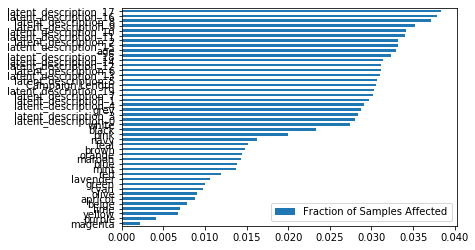

In [35]:
# Plot the feature importance
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : rf.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh')
plt.show()

In [36]:
rf.feature_importances_

array([0.03095603, 0.00919117, 0.00824053, 0.02220102, 0.01411053,
       0.01596608, 0.00906246, 0.01267924, 0.02937388, 0.00984092,
       0.00703228, 0.00365474, 0.01525269, 0.01416243, 0.01430252,
       0.00878717, 0.01630443, 0.02072808, 0.00368881, 0.01253045,
       0.01474331, 0.02826873, 0.00714556, 0.0305014 , 0.03167983,
       0.03360374, 0.03044057, 0.03043781, 0.02924763, 0.03040233,
       0.03410678, 0.03157869, 0.03268709, 0.03126   , 0.03136362,
       0.03160646, 0.03433323, 0.02974186, 0.03347083, 0.03119886,
       0.03333468, 0.03037213, 0.03086844, 0.03954094])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [73]:
y_pred = rf.predict(x_test)
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

       False       0.97      0.74      0.84      1005
        True       0.28      0.78      0.41       125

    accuracy                           0.75      1130
   macro avg       0.62      0.76      0.62      1130
weighted avg       0.89      0.75      0.79      1130



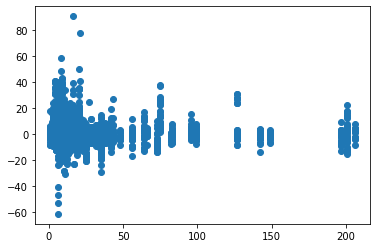

In [31]:
plt.scatter(test_df['age'],test_df['campaign_success'])

In [238]:
master_test = []
master_color = []
for i in df2['Image Name'][0:2]:
    temp_list = google_vis(i)
    master_color.append(temp_list[0])
    master_test.append(temp_list[1])

In [58]:
for i in temp.keys():
    temp[i] = sum(d[i] for d in master_color) / len(master_color)

In [67]:
temp

{'apricot': 0.0032384962785047488,
 'beige': 0.009949879656842613,
 'black': 0.1343126305721823,
 'blue': 0.055156006915290115,
 'brown': 0.011209728710537593,
 'cyan': 0.013267482582295497,
 'green': 0.0025704831939067814,
 'grey': 0.0365737178593178,
 'lavender': 0.002331209507167012,
 'lime': 0.019611653672265156,
 'magenta': 9.180297358677938e-05,
 'maroon': 0.027092619517633875,
 'mint': 0.012284019117622258,
 'navy': 0.0395328986412426,
 'olive': 0.001737420073618273,
 'orange': 0.014232390478335239,
 'pink': 0.032091974741318724,
 'purple': 7.71535611660271e-05,
 'red': 0.07705394494869225,
 'teal': 0.005716199758923152,
 'white': 0.47037889168004154,
 'yellow': 0.03148939555950954}

In [65]:
temp = {'apricot': 0,
     'beige': 0,
     'black': 0,
     'blue': 0,
     'brown': 0,
     'cyan': 0,
     'green': 0,
     'grey': 0,
     'lavender': 0,
     'lime': 0,
     'magenta': 0,
     'maroon': 0,
     'mint': 0,
     'navy': 0,
     'olive': 0,
     'orange': 0,
     'pink': 0,
     'purple': 0,
     'red': 0,
     'teal': 0,
     'white': 0,
     'yellow': 0}

In [81]:
color_list = temp.keys()

In [85]:
color_list = ['pink', 'beige', 'black', 'blue', 'brown', 'cyan', 'green', 'grey', 'lavender', 'lime', 'magenta', 'maroon', 'green', 'navy', 'olive', 'orange', 'pink', 'purple', 'red', 'teal', 'white', 'yellow']

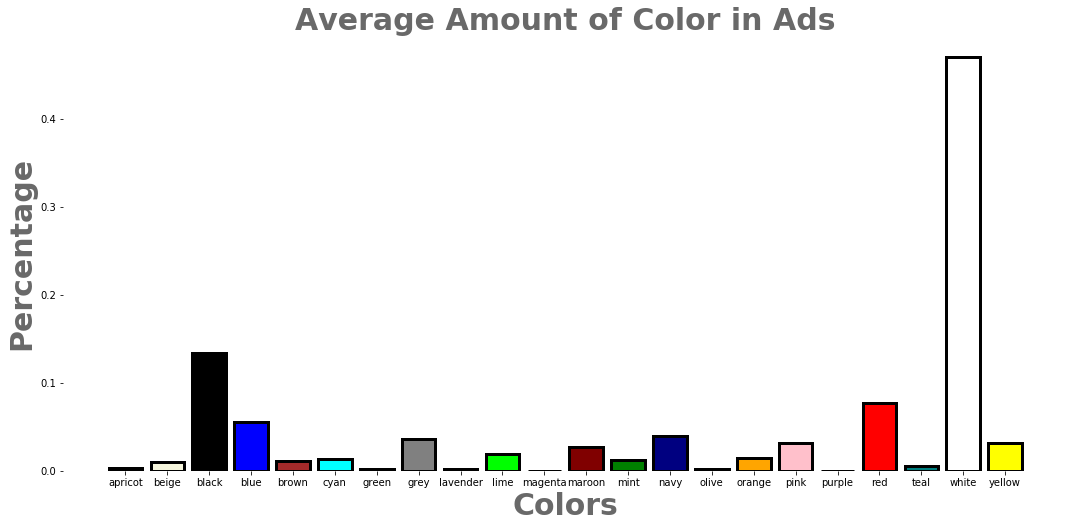

In [141]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (18,8))
pos = np.arange(len(temp.values()))
width = 1.0     # gives histogram aspect to the bar diagram

ax = plt.axes()
# ax.set_xticks()
font = {'fontname' : 'Myriad Hebrew',
        'weight' : 'bold',
        'size'   : 30,
       'color': 'dimgray'}

from pylab import *
axes(frameon = 0)
ax.set_xticklabels(color_list, rotation=90)
plt.ylabel('Percentage', fontdict=font)
plt.title('Average Amount of Color in Ads', fontdict=font)

plt.xlabel('Colors',fontdict=font)
plt.bar(temp.keys(), temp.values(), color=color_list, edgecolor="black", lw=3)                       
plt.show()

In [8]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pandas as pd
import numpy as np

In [3]:
image_data = pd.read_pickle('word_cloud')

In [23]:
str1 = '\n'.join(''.join(sub) for sub in image_data)

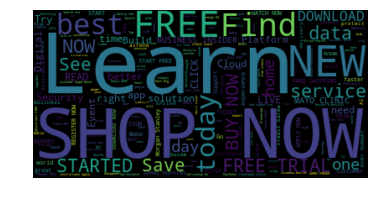

In [26]:
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(str1)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

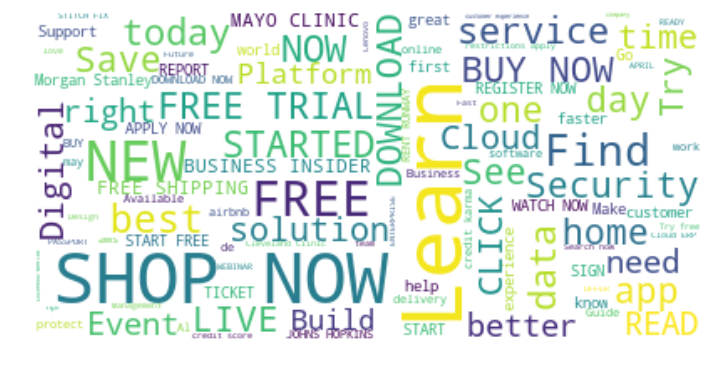

In [28]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(str1)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig('wordjumble', dpi=500, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches=None, pad_inches=0,
        frameon=None, metadata=None)
plt.show()

In [ ]:
'''this function has been copied into get_images.py'''


# def get_images(df_companies=df_companies, start_row = 0, file_path='/Users/ian/Documents/week3/Capstone1/images/')   
#     """
#         A scrapy splash bot which pushes data requests into MOAT.com to grab creative along with information about when
#         it was live
        
#         Parameters
#         ----------
#         df_companies : pandas dataframe : str
#             must have a column titled 'Moat Name' with a list of companies for the bot to iterate through
            
#         start_row : int
#             if the function errors out due to moat sending unprocessable data, the function might need to be restarted from a 
#             specific point within df_companies
            
#         file_path : str
#             the location to save images to disc
            
#         returns:
#             a pandas dataframe with the following columns
#             'Companies Brand','Brand','Image Name','First Seen','Last Seen','Screenpath'
#         """
    
#     #creates an empty dataframe for the MOAT data to be populated into
#     df_moat = pd.DataFrame(columns=['Companies Brand','Brand','Image Name','First Seen','Last Seen','Screenpath'])

#     #pulls in a count with the total number of images saved through this function. Used for naming convention when saving 
#     #files to disc
#     test = open('master_count.txt','r') 
#     master_count = int(test.read())

#     # iterates through the company names and 
#     for company in list(df_companies['Moat Name'][start_row:]):
#         #push a from request into MOAT's AWS server and returns JSON with pathname information to access a companies creatives
#         URL = 'https://moat.com/api/entity_report/advertiser/'+company+'/creatives_query_info?end_date=2019-06-26&filter=all&report_type=display&start_date=2012-05-01'
#         # Get the HTML content of the web page as a string.
#         content = requests.get(URL).content
#         #load content into JSON
#         f = json.loads(content)
#         time.sleep(4)

#         #this portion of the function uses scrapy splash to grab information regarding the creative and saves it into a dataframe
#         #along with the image which is saved to disc

#         # page range will determine how many pages of creatives to pull from the company
#         for page_num in range(0,2):
#             try:
#                 # takes the JSON requested above and iterates through AJAX JSON files to grab creative information and link locations
#                 URL = 'https://moat.com'+(f['base_creative_url'])+'?device=desktop&device=mobile&end_date='+f['max_date']+'&filter=all&load_time='+str(f['load_time'])+'&page='+str(page_num)+'&page_size=42&period=month&report_type=display&start_date='+f['min_date']+'&time_hash='+f['time_hash']
#                 # Get the HTML content of the web page as a string.
#                 content = requests.get(URL).content
#                 #load content into JSON
#                 j = json.loads(content)
#                 for i in range(len(j['creative_data'])):
#                     #checks to see if the creative being examined is a 300x250
#                     if (j['creative_data'][i]['dims'][0] == 300) & (j['creative_data'][i]['dims'][1] == 250):
#                         df_moat.loc[master_count] = str(company),j['creative_data'][i]['brand']['name'], j['creative_data'][i]['brand']['name']+str(master_count)+'.jpg', j['creative_data'][i]['first_seen'], j['creative_data'][i]['last_seen'], j['creative_data'][i]['screenpath']
#                         #saves the image down to drive
#                         urllib.request.urlretrieve(j['creative_data'][i]['screenpath'],file_path +j['creative_data'][i]['brand']['name']+str(master_count)+'.jpg')
#                         #master count is used to create a unique creative name which will allows google creative 
#                         #cloud to read and parce each component
#                         master_count += 1
#             except:
#                 continue       
#             time.sleep(random.randint(18,25))

#     # changes the datetime columns type
#     df_moat['First Seen'] = pd.to_datetime(df_moat['First Seen'])
#     df_moat['Last Seen'] = pd.to_datetime(df_moat['Last Seen'])
#     #adds two new columns with dates before the campaign started and after it ended
#     df_moat['before_campaign'] = df_moat['First Seen'] - pd.DateOffset(months=4)
#     df_moat['after_campaign'] = df_moat['Last Seen'] + pd.DateOffset(months=4)

#     # saves the master count from creatives to a .txt file
#     with open('master_count.txt', 'w') as f:
#         f.write(str(master_count))
        
#     return df_moat

In [ ]:
# df[df['Organization Name'].str.match('SunPower')]